## INITIALIZATION

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from bitarray import bitarray
from tjmonopix.tjmonopix import TJMonoPix
%matplotlib notebook

from tjmonopix.online_monitor import noise_monitor, plots

In [2]:
##### if HV is on, no_power_reset=True,
##### if GPAC had power reset then no_power_reset=False

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml",no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45

2022-01-31 12:03:02,236 [INFO ] (MainThread) GPAC: power reset
2022-01-31 12:03:04,009 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-01-31 12:03:04,256 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-01-31 12:03:04,503 [INFO ] (MainThread) ibias = 45
2022-01-31 12:03:04,526 [INFO ] (MainThread) ibias = 503.125 nA
2022-01-31 12:03:05,088 [INFO ] (MainThread) {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 50.151368865825674, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5006537, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0612799558568045, 'VDDD OC': False, 'VPC [mA]': -0.02249989557596879, 'VPCSWSF [mA]': 0.08104021783687393, 'VDDA [V]': 1.8058565495495498, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10109892318840588}


## POWER STATUS

In [3]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
power_status = chip.get_power_status(printen=True)

BiasSF [V] = 1.0622801786
BiasSF [mA] = 0.100594470965
VDDA OC = False
VDDA [V] = 1.80585654955
VDDA [mA] = 50.1513688658
VDDA_DAC OC = False
VDDA_DAC [V] = 1.80354845155
VDDA_DAC [mA] = 2.50247174749
VDDD OC = False
VDDD [V] = 1.80151403636
VDDD [mA] = 2.82028899904e-08
VDDP OC = False
VDDP [V] = 1.80498027711
VDDP [mA] = 128.397148053
VPC [V] = 1.29935158047
VPC [mA] = -0.0504997722274
VPCSWSF [V] = 0.5006537
VPCSWSF [mA] = 0.12356131663


## COLUMN SETTINGS: FLAVOURS, MASKS, INJECTION

In [4]:
# SELECT WHICH DOUBLE COLUMNS (PIXEL "FLAVOURS") TO ENABLE
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_HV'].setall(True)
chip['CONF_SR']['EN_OUT'].setall(False) #ENABLES OR DISABLES THE NORMAL OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['nEN_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['EN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE NORMAL HITOR PADS, HITOR0-3 =  1-4 flavor, ACTIVE LOW
chip['CONF_SR']['nEN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY HITOR PADS, ACTIVE LOW

chip.write_conf()

In [5]:
# SELECT WHICH PHYSICAL COLUMNS, ROWS, DIAGONALS TO MASK
# TO MASK ONE PIXEL, MASKV, MASKH and MASKD OF THIS PIXEL SHOULD BE 0 (FALSE)
# THE MASKD NUMBER OF THE PIXEL WE WANT TO MASK (or UNMASK), IS GIVEN BY: MASKD = PHYSCOL- PHYSROW
# IF PHYSCOL-PHYSROW<0, then MASKD = 448+PHYSCOL-PHYSROW
chip['CONF_SR']['MASKD'].setall(True)
chip['CONF_SR']['MASKH'].setall(True)
chip['CONF_SR']['MASKV'].setall(True)

# TO USE THE MASK FUNCTION YOU MUST INPUT THE FLAVOR, COLUMN AND ROW
# THE FLAVOR NUMERS IS: 0 FOR PMOS_NOSF, 1 FOR PMOS, 2 FOR COMP, 3 FOR HV

chip.write_conf()

In [6]:
# SELECT WHICH PHYSICAL COLUMS TO INJECT
# INJ_IN_MON_L AND INJ_IN_MON_L SELECT THE LEFT AND RIGHT SPECIAL ANALOG MONITORING PIXELS
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)

chip['CONF_SR']['INJ_IN_MON_L'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS LEFT SIDE
chip['CONF_SR']['INJ_IN_MON_R'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS RIGHT SIDE

# SELECT WHICH PHYSICAL ROWS TO INJECT
# THE SPEXIAL PIXELS OUTA_MON3 to OUTA_MON0 CORRESPONT TO ROWS 223 to 220 FOR INJECTION
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['INJ_ROW'][223:220] = True # FOR THE ANALOG MONITORING TOP PIXEL

# SELECT PHYSICAL COLUMNS AND ROWS FOR INJECTION WITH FUNCTION
#chip.enable_injection(3,18,99)

chip.write_conf()

In [7]:
# SELECT PHYSICAL COLUMN(S) FOR HITOR OUTPUT
# nMASKH (SO SETTING MASKH TO FALSE) ENABLES HITOR FOR THE SPECIFIC ROW
chip['CONF_SR']['DIG_MON_SEL'].setall(False)
#chip.enable_column_hitor(1,18)

chip.write_conf()

## ANALOG FRONT END CONFIGURATION

In [8]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator
ibias_dac = 100


## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# Cinj=230aF => 1.43e-/mV
# VDAC LSB=14.17mV => 20.3e-/LSB
# The default values are VL=44, VH=79, VH-VL=35 => ~710e-
CALCAP=33 ## 33 or 14.17E-3*230E-18/1.602E-19=20.3
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

2022-01-31 12:03:13,178 [INFO ] (MainThread) vl = 0.951929133858V
2022-01-31 12:03:13,194 [INFO ] (MainThread) vh = 1.51885826772V


In [9]:
# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-01-31 12:03:15,627 [INFO ] (MainThread) vreset = 1.05106299213V
2022-01-31 12:03:15,641 [INFO ] (MainThread) icasn = 0
2022-01-31 12:03:15,657 [INFO ] (MainThread) icasn = 4.375 nA
2022-01-31 12:03:15,674 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-01-31 12:03:15,710 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-01-31 12:03:15,726 [INFO ] (MainThread) ithr = 5
2022-01-31 12:03:15,742 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-01-31 12:03:15,757 [INFO ] (MainThread) idb = 50
2022-01-31 12:03:15,773 [INFO ] (MainThread) idb = 892.5 nA
2022-01-31 12:03:15,779 [INFO ] (MainThread) ibias = 100
2022-01-31 12:03:15,796 [INFO ] (MainThread) ibias = 1104.6875 nA


For using external ICASN instead:
```python
chip['DACMON_ICASN'].set_current(0, unit='uA')
chip['CONF_SR']['SWCNTL_ICASN']=True
chip.write_conf()
time.sleep(1)
print chip['DACMON_ICASN'].get_voltage()
print chip['DACMON_ICASN'].get_current()
```

## ENABLE MASK

Got 219000 hits in 0.2 s


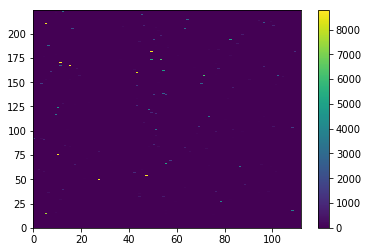

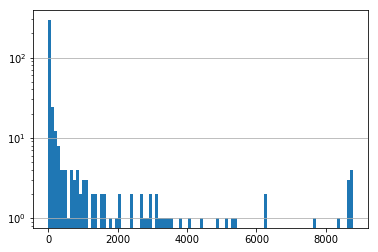

In [10]:
chip.unmask_all()
plots.tj_plot(chip);

Enable MASKH 50
Got 51830 hits, total noisy pixels: 35
Enable MASKH 100
Got 109378 hits, total noisy pixels: 97
Enable MASKH 150
Got 26889 hits, total noisy pixels: 148
Enable MASKH 200
Got 157801 hits, total noisy pixels: 207
Enable MASKH 223
Got 37717 hits, total noisy pixels: 227
Enable MASKV 50
Got 77 hits, total noisy pixels: 230
Enable MASKV 100
Got 104 hits, total noisy pixels: 235
Enable MASKV 111
Got 5 hits, total noisy pixels: 236
Enable MASKD 50
Got 119 hits, total noisy pixels: 236
Enable MASKD 100
Got 3 hits, total noisy pixels: 236
Enable MASKD 150
Got 43 hits, total noisy pixels: 237
Enable MASKD 200
Got 44 hits, total noisy pixels: 241
Enable MASKD 250
Got 63 hits, total noisy pixels: 245
Enable MASKD 300
Got 100 hits, total noisy pixels: 246
Enable MASKD 350
Got 47 hits, total noisy pixels: 251
Enable MASKD 400
Got 19 hits, total noisy pixels: 254
Enable MASKD 447
Got 110 hits, total noisy pixels: 258
Checking again after masking
Got 35 hits, total noisy pixels: 262
No

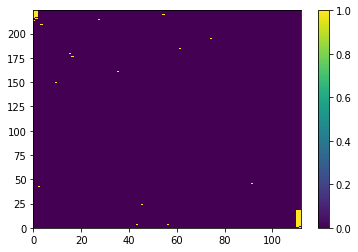

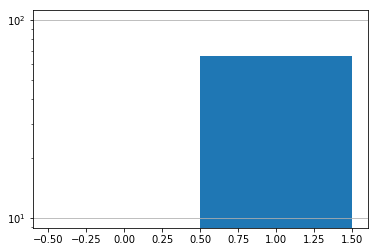

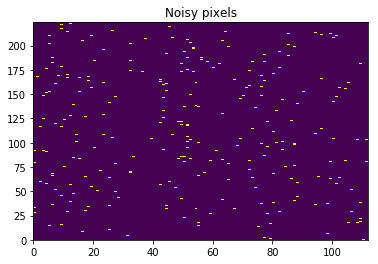

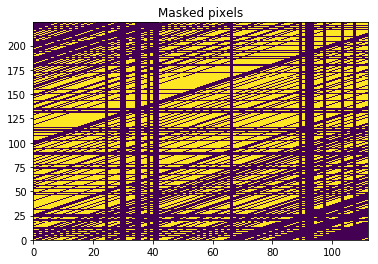

In [11]:
""" Software parameters to select: 
    the threshold above whitch a pixel is defined noisy (th = number of hits per pixel), 
    the step (),
    the time of the data acquisition run (in s) """
th = 2
step = 50
dt = 0.2

# Auto-mask and plot again
noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
plots.tj_plot(chip);

plt.figure()
plt.subplot(1, 2, 1)
plt.hist2d([x[1] for x in noisy_pixels], [x[2] for x in noisy_pixels], bins=[112,224], range=[[0,112],[0,224]])
plt.title("Noisy pixels")
plt.xlabel('rows')
plt.ylabel('columns')

plt.subplot(1, 2, 2)
plt.hist2d([x[0] for x in mask], [x[1] for x in mask], bins=[112,224], range=[[0,112],[0,224]])
plt.title("Masked pixels")
plt.xlabel('rows')
plt.ylabel('columns')
plt.show()

## OCCUPANCY

In [14]:
pix_tmp, cnt = chip.get_occupancy(dt);

Number of pixels counted: 16
column, row) hits 

(29, 39) 2
(4, 186) 2
(105, 46) 1
(94, 93) 1
(88, 78) 1
(66, 85) 1
(62, 26) 1
(61, 184) 1
(56, 3) 1
(53, 179) 1
(52, 24) 1
(46, 134) 1
(36, 166) 1
(35, 160) 1


In [ ]:
#save some outout monitor files
date_string = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

output_file_power_status = date_string + 'power_status.txt'
output_file_parameters = 'parameters.txt'
output_file_noisy_pixels = date_string + '_noisy_pixels.txt'
output_file_hits_per_pixels = date_string + '_hits_pixels.txt'

noise_monitor.save_noisy_pixels(np.array(list(noisy_pixels)), output_file_noisy_pixels)
noise_monitor.save_param_and_noise(
    setted_param_dac, setted_param, len(noisy_pixels), n_disabled_pixels, output_file_parameters)
noise_monitor.save_power_status(power_status, output_file_power_status)

#noise_monitor.save_hits_per_pixels(hits, pixels, hits_per_pixel, output_file_hits_per_pixels)

# ENABLE INJECTION

Got 169 hits in 0.2 s
((0, 211), 1)
((110, 5), 1)
((110, 6), 1)
((110, 7), 1)
((110, 8), 1)
((110, 9), 1)
((110, 10), 1)
((110, 11), 1)
((110, 12), 1)
((110, 13), 1)
((110, 14), 1)
((110, 15), 1)
((110, 16), 1)
((110, 17), 1)
((111, 0), 1)
((110, 4), 1)
((111, 2), 1)
((111, 4), 1)
((111, 5), 1)
((111, 6), 1)
((111, 7), 1)
((111, 8), 1)
((111, 9), 1)
((111, 10), 1)
((111, 11), 1)
((111, 12), 1)
((111, 13), 1)
((111, 14), 1)
((111, 15), 1)
((111, 16), 1)
((111, 17), 1)
((111, 3), 1)
((111, 18), 1)
((110, 3), 1)
((110, 1), 1)
((0, 213), 1)
((0, 216), 1)
((0, 217), 1)
((0, 218), 1)
((0, 219), 1)
((0, 220), 1)
((0, 221), 1)
((0, 222), 1)
((0, 223), 1)
((1, 215), 1)
((1, 217), 1)
((1, 218), 1)
((1, 219), 1)
((1, 220), 1)
((110, 2), 1)
((1, 221), 1)
((1, 223), 1)
((8, 164), 1)
((35, 160), 1)
((44, 210), 1)
((54, 29), 1)
((66, 85), 1)
((68, 179), 1)
((88, 78), 1)
((94, 74), 1)
((102, 55), 1)
((1, 222), 1)
((111, 20), 1)
((4, 186), 2)
((7, 8), 2)
((46, 134), 2)
((18, 25), 100)


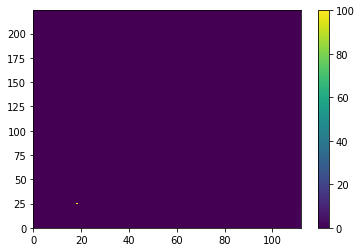

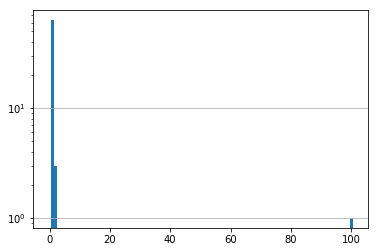

In [20]:
col_to_inject = 18
row_to_inject = 25

delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
chip.enable_injection(3, col_to_inject, row_to_inject)
chip.write_conf()

_, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
chip['data_rx'].set_en(False)


## INJECTION SCANS -  S-CURVE

In [21]:
inj_low_dac = chip.get_vl_dacunits()
inj_low = vl
chip['data_rx'].set_en(True)
for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
time.sleep(2)

#it is a signal from 40DAC (=vl) to 120DAC (=vh) and corresponds to a signal in 0.95-2.28V
#
injlist = np.arange(80, 0, -1)  
cnt = np.empty(len(injlist))
tot = np.empty(len(injlist))
inj_high = np.empty(len(injlist))

for inj_i, inj in enumerate(injlist):
    inj_high_pulse_dac = inj + inj_low_dac
    inj_high_pulse = chip.set_vh_dacunits(inj_high_dac, 0)
    chip.write_conf()
    for _ in range(5):
        chip['fifo'].reset()
        time.sleep(0.002)
    chip.set_monoread()
    chip["inj"].start()
    while not chip['inj'].is_ready:
        time.sleep(0.001)
    time.sleep(0.02)
    
    ix = chip.interpret_data(chip['fifo'].get_data())
    ix_inj = ix[np.bitwise_and(ix["col"] == col_to_inject, ix["row"] == row_to_inject)]
    print inj, inj_high_pulse, len(ix), len(ix_inj), np.average((ix_inj["te"] - ix_inj["le"]) & 0x3F)
    cnt[inj_i] = len(ix_inj)
    tot[inj_i] = np.average((ix_inj["te"]-ix_inj["le"]) & 0x3F)
    inj_high[inj_i] = inj_high_pulse

80 100 100 44.28
79 105 100 44.21
78 101 100 44.13
77 107 100 44.12
76 106 100 44.43
75 102 100 44.13
74 111 100 44.11
73 100 100 44.05
72 100 100 44.15
71 106 100 43.8
70 106 100 43.91
69 102 100 43.88
68 105 100 43.69
67 104 100 43.56
66 102 100 43.55
65 102 100 43.22
64 102 100 42.97
63 100 100 42.6
62 104 100 41.56
61 102 100 41.51
60 103 100 41.07
59 104 100 40.31
58 108 100 39.64
57 105 100 38.71
56 104 100 38.14
55 104 100 37.24
54 101 100 36.42
53 104 100 35.54
52 103 100 34.98
51 101 100 33.97
50 103 100 32.94
49 104 100 32.02
48 107 100 31.2
47 102 100 29.88
46 102 100 28.39
45 102 100 27.2
44 102 100 26.42
43 103 100 25.52
42 103 100 23.91
41 100 100 22.36
40 102 100 21.54
39 101 100 20.5
38 101 100 19.25
37 102 100 18.11
36 105 100 16.67
35 102 100 15.51
34 107 100 14.08
33 104 100 13.16
32 105 100 12.06
31 103 100 10.7
30 102 100 9.67
29 101 100 8.28
28 103 100 6.98
27 102 100 5.53
26 100 97 4.752577319587629
25 84 83 4.0843373493975905
24 80 77 3.4935064935064934
23 73 70

C:\ProgramData\Miniconda2\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Miniconda2\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


13 4 0 nan
12 5 0 nan
11 2 0 nan
10 7 0 nan
9 8 0 nan
8 5 0 nan
7 2 0 nan
6 2 0 nan
5 3 0 nan
4 1 0 nan
3 3 0 nan
2 5 0 nan
1 4 0 nan


approx. th = 21 DAC = 693 e-


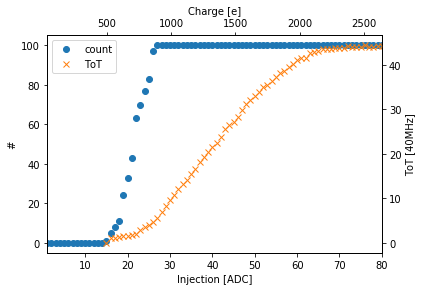

In [22]:
threshold, sigma = plot.s_curve(injlist, inj_high, cnt, repeat, CALCAP)